In [1]:
import sys
sys.path.append('..')

! pip install shapely
! pip install shap

! pip install --upgrade scikit-learn==0.22.0 -i https://pypi.tuna.tsinghua.edu.cn/simple/ 

! sudo apt-get remove python3-pip
! sudo apt-get install python3-pip


! pip3 uninstall scikit-learn
! pip3 install -U scikit-learn==0.21.3


In [2]:
import sklearn
print(sklearn.__version__)


0.21.3


! pip install lime
! pip install xgboost


In [3]:
from inxai import *
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

# Create syntheti classification dataset

In [4]:
n_features = 4
X, y = make_classification(n_samples=100, n_informative=2, n_features=n_features, n_redundant=2)
X = preprocessing.normalize(X)
X=pd.DataFrame(data=X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## XGBoost

In [6]:
X_train.columns = ['0','1','2','3']
X_test.columns = ['0','1','2','3']
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))

0.8787878787878788
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.85      0.94      0.89        18

    accuracy                           0.88        33
   macro avg       0.89      0.87      0.88        33
weighted avg       0.88      0.88      0.88        33



### Permutation importance

In [7]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
perm_importances = perm.feature_importances_
feature_names = [str(i) for i in range(n_features)]
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2424 ± 0.0664,0
0.1030 ± 0.0985,2
-0.0121 ± 0.0297,3
-0.0182 ± 0.0485,1


In [8]:
gm = GlobalFeatureMetric()

In [9]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test.columns)])


In [10]:
acc_loss = gm.gradual_perturbation(model=xgb_model, X=X_test, y=y_test, column_transformer=ct, importances_orig=perm_importances, resolution=50,  count_per_step=10)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


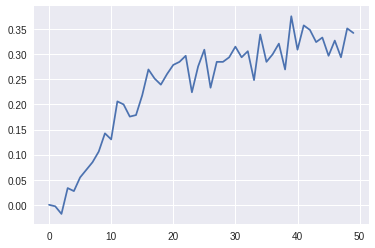

In [12]:
plt.plot(acc_loss)
plt.show()


### Check stability

In [13]:
shape_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='tree_shap') )

invalid value encountered in true_divide


In [14]:
lime_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='lime') )

invalid value encountered in double_scalars


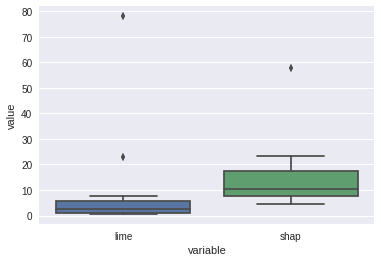

In [15]:
lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Check consistency

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
res = generate_per_instance_importances(models=[xgb_model, lr], X=X_test, y=y_test, framework='lime') 

In [18]:
lime_cons = gm.consistency(res)

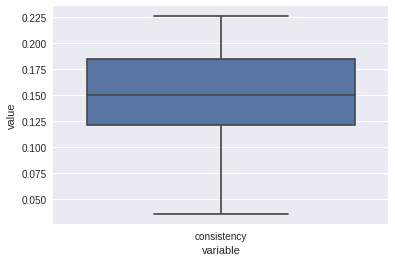

In [19]:
lip_df = pd.DataFrame({'consistency':lime_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [21]:
res2 = generate_per_instance_importances(models=[xgb_model, lr], X=X_test, y=y_test, framework='tree_shap') 

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model.logistic.LogisticRegression'>